In [ ]:
!pip install keras_tuner
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
from sklearn.preprocessing import StandardScaler

import keras
import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

import random

SEED_VALUE = 100
np.random.seed(SEED_VALUE)       
random.seed(SEED_VALUE)            
tf.random.set_seed(SEED_VALUE)      

# Import Dataset

In [ ]:
df = pd.read_csv("AMZN.csv")
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
5,1997-05-22,1.437500,1.447917,1.312500,1.395833,1.395833,11776800
6,1997-05-23,1.406250,1.520833,1.333333,1.500000,1.500000,15937200
7,1997-05-27,1.510417,1.645833,1.458333,1.583333,1.583333,8697600
8,1997-05-28,1.625000,1.635417,1.531250,1.531250,1.531250,4574400
9,1997-05-29,1.541667,1.541667,1.479167,1.505208,1.505208,3472800


In [ ]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
6247,2022-03-11,2991.489990,2993.500000,2907.379883,2910.489990,2910.489990,3440500
6248,2022-03-14,2919.620117,2949.000000,2817.679932,2837.060059,2837.060059,3704300
6249,2022-03-15,2857.000000,2959.699951,2840.000000,2947.330078,2947.330078,3779200
6250,2022-03-16,2970.000000,3063.000000,2947.070068,3062.080078,3062.080078,4247900
6251,2022-03-17,3052.810059,3149.969971,3042.800049,3144.780029,3144.780029,3646700
6252,2022-03-18,3136.260010,3231.879883,3120.219971,3225.010010,3225.010010,5141300
6253,2022-03-21,3222.419922,3261.679932,3191.060059,3229.830078,3229.830078,3326900
6254,2022-03-22,3236.110107,3323.340088,3233.979980,3297.780029,3297.780029,3204300
6255,2022-03-23,3274.100098,3327.399902,3253.739990,3268.159912,3268.159912,2790600
6256,2022-03-24,3274.989990,3282.370117,3201.000000,3272.989990,3272.989990,2834900


# EDA

In [ ]:
df.shape

(6257, 7)

The dataset consist of 5 columns and 6,257 records

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6257 entries, 0 to 6256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6257 non-null   object 
 1   Open       6257 non-null   float64
 2   High       6257 non-null   float64
 3   Low        6257 non-null   float64
 4   Close      6257 non-null   float64
 5   Adj Close  6257 non-null   float64
 6   Volume     6257 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 342.3+ KB


All variables, except for Date, have numeric data types. The Date variable has a data type of object (string).

# Data Preprocessing

I will do univariate time series prediction using only the Date and Close columns.

In [ ]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,1997-05-15,1.958333
1,1997-05-16,1.729167
2,1997-05-19,1.708333
3,1997-05-20,1.635417
4,1997-05-21,1.427083


I change the Date datatype to datetime and then set it as the index.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df.head(10)

,Close
Date,
1997-05-15,1.958333
1997-05-16,1.729167
1997-05-19,1.708333
1997-05-20,1.635417
1997-05-21,1.427083
1997-05-22,1.395833
1997-05-23,1.500000
1997-05-27,1.583333
1997-05-28,1.531250


In [ ]:
df_2022 = df[df.index.year == 2022]

mean_close_2022 = df_2022['Close'].mean()

mean_close_2022

3069.3273883157894

The mean closing price of AMZN stock in 2022 is 3069 USD.








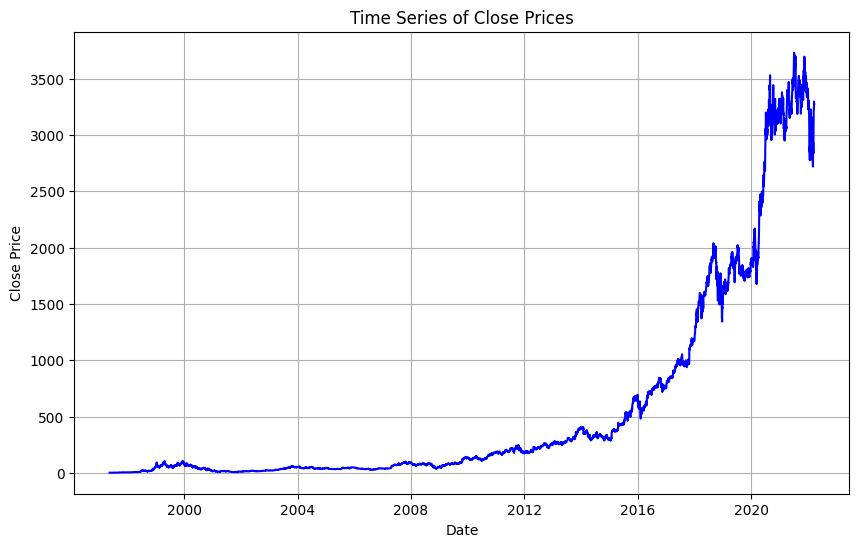

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], color='b')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Time Series of Close Prices')
plt.grid(True)
plt.show()

The graph above shows that the price of AMZN stock tends to increase each year.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6257 entries, 1997-05-15 to 2022-03-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   6257 non-null   float64
dtypes: float64(1)
memory usage: 97.8 KB


Now the data is univariate, focusing on the single variable 'Close'.

In [ ]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

for i in range (0, 7):
    day_name = days[df.index[i].weekday()]
    print(f"Date {df.index[i].date()} = {day_name}")

Date 1997-05-15 = Thursday
Date 1997-05-16 = Friday
Date 1997-05-19 = Monday
Date 1997-05-20 = Tuesday
Date 1997-05-21 = Wednesday
Date 1997-05-22 = Thursday
Date 1997-05-23 = Friday


## I will use data from Monday to Friday to predict the stock price for the following Monday.

The dataset starts with Thursday, followed by Friday, and the third record is Monday. Since I need 5 continuous days (Monday to Friday) to predict the close price for the next Monday, I will not use the first 2 records.

In [ ]:
day_name = days[df.index[-1].weekday()]
print(f"Tanggal {df.index[-1].date()} = {day_name}")

Tanggal 2022-03-24 = Thursday


 The last record in this dataset is 2020-04-01, which is a Wednesday.

Below, I create df_day which is used to check the days with the requirement of having complete data from Monday to Friday for each week.

In [ ]:
df_day = df.copy()
df_day['Day'] = df.index.day_name()
df_day.head(10)

,Close,Day
Date,,
1997-05-15,1.958333,Thursday
1997-05-16,1.729167,Friday
1997-05-19,1.708333,Monday
1997-05-20,1.635417,Tuesday
1997-05-21,1.427083,Wednesday
1997-05-22,1.395833,Thursday
1997-05-23,1.500000,Friday
1997-05-27,1.583333,Tuesday
1997-05-28,1.531250,Wednesday


In [ ]:
df_day.tail(10)

,Close,Day
Date,,
2022-03-11,2910.489990,Friday
2022-03-14,2837.060059,Monday
2022-03-15,2947.330078,Tuesday
2022-03-16,3062.080078,Wednesday
2022-03-17,3144.780029,Thursday
2022-03-18,3225.010010,Friday
2022-03-21,3229.830078,Monday
2022-03-22,3297.780029,Tuesday
2022-03-23,3268.159912,Wednesday


In [ ]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

days = df_day['Day'].tolist()

# for i in range(2,len(days)):
for i in range(2, 25):
  day_correct_pattern = days_of_week[(i % len(days_of_week)) - 2]
  if days[i] != day_correct_pattern:
    print(f"Index: {df_day.index[i]}, Hari pada dataset adalah '{df_day['Day'].iloc[i]}', namun menurut pola seharusnya '{day_correct_pattern}'.")

Index: 1997-05-27 00:00:00, Hari pada dataset adalah 'Tuesday', namun menurut pola seharusnya 'Monday'.
Index: 1997-05-28 00:00:00, Hari pada dataset adalah 'Wednesday', namun menurut pola seharusnya 'Tuesday'.
Index: 1997-05-29 00:00:00, Hari pada dataset adalah 'Thursday', namun menurut pola seharusnya 'Wednesday'.
Index: 1997-05-30 00:00:00, Hari pada dataset adalah 'Friday', namun menurut pola seharusnya 'Thursday'.
Index: 1997-06-02 00:00:00, Hari pada dataset adalah 'Monday', namun menurut pola seharusnya 'Friday'.
Index: 1997-06-03 00:00:00, Hari pada dataset adalah 'Tuesday', namun menurut pola seharusnya 'Monday'.
Index: 1997-06-04 00:00:00, Hari pada dataset adalah 'Wednesday', namun menurut pola seharusnya 'Tuesday'.
Index: 1997-06-05 00:00:00, Hari pada dataset adalah 'Thursday', namun menurut pola seharusnya 'Wednesday'.
Index: 1997-06-06 00:00:00, Hari pada dataset adalah 'Friday', namun menurut pola seharusnya 'Thursday'.
Index: 1997-06-09 00:00:00, Hari pada dataset ada

With just the first 25 records, it is apparent that many dates do not follow the pattern (some dates are missing).




The data to be dropped will have the value 'Pattern' set to 'False'. So, for each 'Monday' found, it will check 'Tuesday' through 'Friday'. If the check confirms that Monday through Friday are complete and consecutive, then the 'Pattern' value in the column will be set to 'True'.

In [ ]:
df_day['Pattern'] = False

try:
    for i in range(2, len(df_day)):
        if (df_day['Day'].iloc[i] == 'Monday' and
            df_day['Day'].iloc[i+1] == 'Tuesday' and
            df_day['Day'].iloc[i+2] == 'Wednesday' and
            df_day['Day'].iloc[i+3] == 'Thursday' and
            df_day['Day'].iloc[i+4] == 'Friday'):
            df_day.loc[df_day.index[i], 'Pattern'] = True
            df_day.loc[df_day.index[i+1], 'Pattern'] = True
            df_day.loc[df_day.index[i+2], 'Pattern'] = True
            df_day.loc[df_day.index[i+3], 'Pattern'] = True
            df_day.loc[df_day.index[i+4], 'Pattern'] = True

except IndexError:
    print("Index out of range. Stopping iteration.")

print(df_day.head(25))

Index out of range. Stopping iteration.
               Close        Day  Pattern
Date                                    
1997-05-15  1.958333   Thursday    False
1997-05-16  1.729167     Friday    False
1997-05-19  1.708333     Monday     True
1997-05-20  1.635417    Tuesday     True
1997-05-21  1.427083  Wednesday     True
1997-05-22  1.395833   Thursday     True
1997-05-23  1.500000     Friday     True
1997-05-27  1.583333    Tuesday    False
1997-05-28  1.531250  Wednesday    False
1997-05-29  1.505208   Thursday    False
1997-05-30  1.500000     Friday    False
1997-06-02  1.510417     Monday     True
1997-06-03  1.479167    Tuesday     True
1997-06-04  1.416667  Wednesday     True
1997-06-05  1.541667   Thursday     True
1997-06-06  1.656250     Friday     True
1997-06-09  1.687500     Monday     True
1997-06-10  1.583333    Tuesday     True
1997-06-11  1.541667  Wednesday     True
1997-06-12  1.604167   Thursday     True
1997-06-13  1.583333     Friday     True
1997-06-16  1.572

In [ ]:
df_day.tail()

,Close,Day,Pattern
Date,,,
2022-03-18,3225.010010,Friday,True
2022-03-21,3229.830078,Monday,False
2022-03-22,3297.780029,Tuesday,False
2022-03-23,3268.159912,Wednesday,False
2022-03-24,3272.989990,Thursday,False


The last Monday (dated 2020-03-30) will have its Pattern set to 'True' so it can be used as the last horizon window.

In [ ]:
df_day.loc[df_day.index[-3], 'Pattern'] = True

In [ ]:
df_day['Pattern'].value_counts()

,count
Pattern,
True,5361
False,896


I separated the time series data into two parts: input and output, with a window size of 5 [from Monday to Friday] and a horizon of 1 [only Monday].

This means that the data used for prediction includes data from Monday to Friday to forecast the stock price for the next Monday.

However, there are instances where some days are missing from the data. For example, if Monday is missing, there are only 4 days in the week instead of the required 5 days for prediction. In this dataset, 827 records have patterns that do not match (not all weekdays from Monday to Friday are present in a week).

Therefore, such data will be dropped

In [ ]:
df_final = df.copy()
df_final = df_final.drop(df_day[df_day['Pattern'] == False].index)
df_final.head(10)

,Close
Date,
1997-05-19,1.708333
1997-05-20,1.635417
1997-05-21,1.427083
1997-05-22,1.395833
1997-05-23,1.500000
1997-06-02,1.510417
1997-06-03,1.479167
1997-06-04,1.416667
1997-06-05,1.541667


In [ ]:
df_final.tail(6)

,Close
Date,
2022-03-14,2837.060059
2022-03-15,2947.330078
2022-03-16,3062.080078
2022-03-17,3144.780029
2022-03-18,3225.010010
2022-03-22,3297.780029


In [ ]:
df_final.shape

(5361, 1)

After making adjustments where only data with complete weekdays from Monday to Friday within a week is used, the remaining data is 5,361 records.

# Windowing

In [ ]:
window_size = 5
horizon = 1

x = []
y = []

for i in range(len(df_final) - window_size - horizon + 1):
    if df_final.index[i].day_name() == 'Monday':  # Ensure that it starts from Monday
        # Input (Window)
        window = df_final.iloc[i:i+window_size]['Close'].tolist()
        x.append(window)

        # Output (Prediction)
        prediction = df_final.iloc[i+window_size:i+window_size+horizon]['Close'].iloc[-1]
        y.append(prediction)

x = np.array(x)
y = np.array(y)

print("Shape of x (input):", x.shape)
print("Shape of y (output):", y.shape)

Shape of x (input): (1072, 5)
Shape of y (output): (1072,)


From the shape, there are 1,072 records, which means there will be 1,072 windows and their corresponding predictions in the entire dataset.

In [ ]:
5361/5

1072.2

In [ ]:
print("Hasil Windowing:")
for i in range(len(x)):
    print(f"Window {i+1}: {x[i]} --> Prediction: {y[i]}")

Hasil Windowing:
Window 1: [1.708333 1.635417 1.427083 1.395833 1.5     ] --> Prediction: 1.510417
Window 2: [1.510417 1.479167 1.416667 1.541667 1.65625 ] --> Prediction: 1.6875
Window 3: [1.6875   1.583333 1.541667 1.604167 1.583333] --> Prediction: 1.572917
Window 4: [1.572917 1.505208 1.510417 1.510417 1.526042] --> Prediction: 1.5
Window 5: [1.5      1.510417 1.510417 1.510417 1.489583] --> Prediction: 2.0
Window 6: [2.       2.302083 2.322917 2.5625   2.291667] --> Prediction: 2.135417
Window 7: [2.135417 2.4375   2.333333 2.21875  2.15625 ] --> Prediction: 2.182292
Window 8: [2.182292 2.135417 2.291667 2.260417 2.229167] --> Prediction: 2.322917
Window 9: [2.322917 2.479167 2.447917 2.395833 2.416667] --> Prediction: 2.3125
Window 10: [2.3125   2.208333 2.25     2.177083 2.291667] --> Prediction: 2.328125
Window 11: [2.328125 2.197917 2.197917 2.15625  2.114583] --> Prediction: 2.041667
Window 12: [2.041667 2.166667 2.166667 2.114583 2.125   ] --> Prediction: 2.21875
Window 13: 

# Spliting

I split the data into an 8:1:1 ratio for train, test, and validation sets. The split is sequential: the first 80% is for training, the next 10% for testing, and the remaining 10% for validation.

In [ ]:
total_length = len(x)
train_length = int(total_length * 0.8)
val_length = int(total_length * 0.1)
test_length = total_length - train_length - val_length

x_train = x[:train_length]
y_train = y[:train_length]

x_val = x[train_length:train_length+val_length]
y_val = y[train_length:train_length+val_length]

x_test = x[train_length+val_length:]
y_test = y[train_length+val_length:]

print(f"Train set: {len(x_train)} data points")
print(f"Validation set: {len(x_val)} data points")
print(f"Test set: {len(x_test)} data points")

Train set: 857 data points
Validation set: 107 data points
Test set: 108 data points


In [ ]:
print(x_train.shape)
print(y_train.shape)

(857, 5)
(857,)


In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 500

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(BATCH_SIZE)

# Model 1 - Baseline Model

An LSTM layer with 50 units and ReLU activation is followed by a single-unit Dense layer for prediction.

In [ ]:
from tensorflow.keras.optimizers import Adam


model1 = Sequential([
    LSTM(50, activation='relu', input_shape=(x_train.shape[1], 1)),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)

model1.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
path_checkpoint = "model1_checkpoint.weights.h5"

checkpoint = keras.callbacks.ModelCheckpoint(monitor="val_loss", filepath=path_checkpoint, verbose=1,
                                             save_weights_only=True, save_best_only=True)

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history1 = model1.fit(train_data, validation_data = val_data,
                             epochs=1000, verbose=1,
                             callbacks=[early_stopping, checkpoint])

Epoch 1/1000
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 9804.3701
Epoch 1: val_loss improved from inf to 2837.41772, saving model to model1_checkpoint.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 9792.2080 - val_loss: 2837.4177
Epoch 2/1000
44/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62.9441
Epoch 2: val_loss improved from 2837.41772 to 2450.90015, saving model to model1_checkpoint.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 68.5228 - val_loss: 2450.9001
Epoch 3/1000
51/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44.9707
Epoch 3: val_loss improved from 2450.90015 to 2109.12549, saving model to model1_checkpoint.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 46.4803 - val_loss: 2109.1255
Epoch 4/1000
50/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.7154
Epoch 4: val_loss did not improve from 2109.12549
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.7807 - val_loss: 2883.9836
Epoch 5/1000
43/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 41

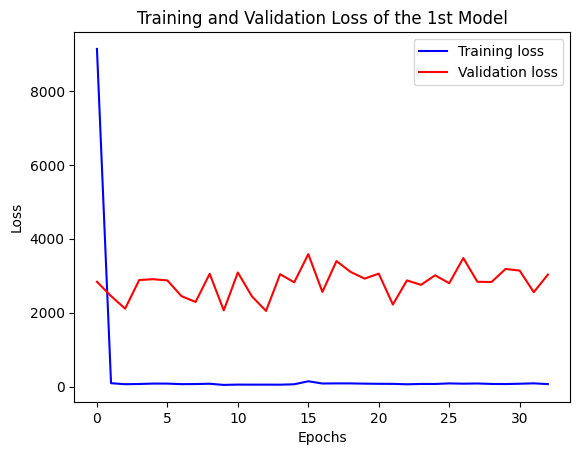

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history1, "Training and Validation Loss of the 1st Model")

From the plot above, it is apparent that there is a large gap between the training loss and validation loss. This indicates that the model is far from being a good fit and is overfitting. Thus, there is still considerable room for improvement for this model.

In [ ]:
y_pred = model1.predict(x_test)

y_pred = y_pred.flatten()
y_test = y_test.flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")

MAE: 79.58202107349537
MSE: 12206.109461834018
RMSE: 110.48126294460079
R²: 0.9665011551946359
MAPE: 2.7477180617568724


The evaluation of Model 1 above indicates that the model performs reasonably well, but there is still room for improvement in predicting the close price of AMZN stock. The MAE value of 79.58 suggests that the model's average prediction error is nearly 80 USD. In 2022, the average AMZN stock price was 3069 USD, so an 80 USD error translates to approximately 2.6% of the stock price. Therefore, reducing this error would be beneficial, as stock prices are crucial.

The R² value of 0.9665 indicates that the model can explain approximately 96.55% of the variation in AMZN stock prices, which is quite high and reflects a strong model. Additionally, the MAPE value of 2.7477% suggests that the average relative error is around 2.75%, which is not too high. Overall, the model's performance is quite good. However, further reducing the error would be ideal, given the importance of stock prices to many stakeholders.

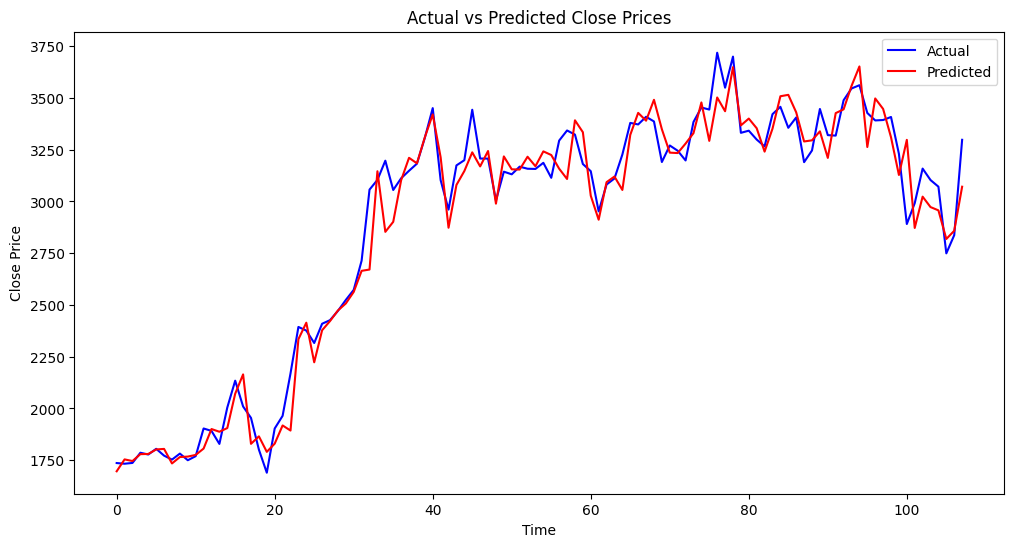

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, color='blue', label='Actual')
plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.legend()
plt.show()

Based on the plot above, the prediction results cannot yet be considered satisfactory. There is a noticeable gap between the actual and predicted close prices.

In [ ]:
keras.backend.clear_session()

# Model 2 - using RandomSearch Tuner

In [ ]:
! pip install keras-tuner

In [ ]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

# Define a HyperModel for Keras Tuner
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=20, max_value=120, step=10),
                        activation='relu',
                        input_shape=(x_train.shape[1], 1)))
        model.add(Dense(1))

        # Use a fixed optimizer type and tune only the learning rate
        optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='LOG'))

        model.compile(
            optimizer=optimizer,
            loss='mean_squared_error'
        )
        return model

In [ ]:
path_checkpoint = 'best_model.weights.h5'  # Change file extension to .weights.h5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor="val_loss", filepath=path_checkpoint, verbose=1,
                                                 save_weights_only=True, save_best_only=True)


# Create the tuner
tuner = RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='tuning_without_optimizer'
)

# Search for the best hyperparameters
tuner.search(x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=[early_stopping, checkpoint])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 17s]
val_loss: 2318.208251953125

Best val_loss So Far: 1880.74951171875
Total elapsed time: 00h 02m 14s


In [ ]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
for param_name in best_hyperparameters.values:
    print(f"{param_name}: {best_hyperparameters.get(param_name)}")

Best Hyperparameters:
units: 70
learning_rate: 0.00013148393815161862


The best hyperparameters are 70 LSTM units and a learning rate of 0.00013.

In [ ]:
# clone the best model so it become model2
model2 = tf.keras.models.clone_model(best_model)
model2.compile(optimizer=best_model.optimizer, loss=best_model.loss, metrics=best_model.metrics)
model2.set_weights(best_model.get_weights())

In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 70)                  │          20,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              71 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,231 (79.03 KB)

 Trainable params: 20,231 (79.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the best model again to get the training history
history2 = best_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=1000,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 43.6014
Epoch 1: val_loss improved from inf to 1989.53503, saving model to best_model.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 43.6479 - val_loss: 1989.5350
Epoch 2/1000
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 37.6254
Epoch 2: val_loss did not improve from 1989.53503
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 38.1610 - val_loss: 2041.9203
Epoch 3/1000
13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.0613 
Epoch 3: val_loss improved from 1989.53503 to 1989.01941, saving model to best_model.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 36.4897 - val_loss: 1989.0194
Epoch 4/1000
21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36.0642
Epoch 4: val_loss did not improve from 1989.01941
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 36.8307 - val_loss: 2056.4675
Epoch 5/1000
16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 33.7929
Epoch 5: val_loss did not improve from 1989.01941
27/27 ━━━━━━━━

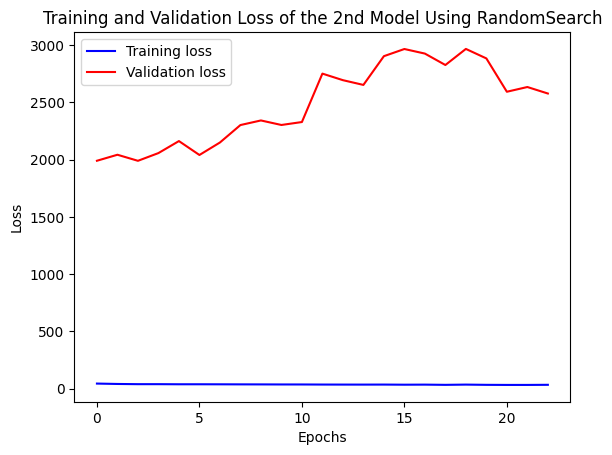

In [ ]:
visualize_loss(history2, "Training and Validation Loss of the 2nd Model Using RandomSearch")

The plot above indicates overfitting; the training loss is close to 0, but the validation loss ranges from 2000 to 2900.

In [ ]:
y_pred = best_model.predict(x_test)

y_pred = y_pred.flatten()
y_test = y_test.flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")

MAE: 67.44802746404802
MSE: 9205.978398361563
RMSE: 95.9477899607988
R²: 0.9747348127089537
MAPE: 2.34744982355018


This model has a lower error than the first model, with an MAE of 67.45 USD and an R² of 97.47%. This indicates that the model has improved compared to the first one.

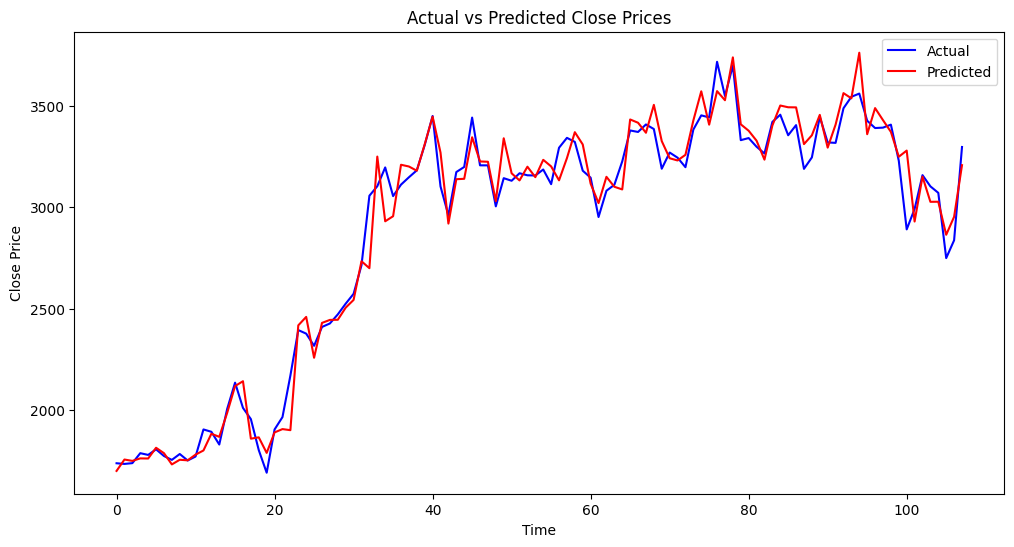

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, color='blue', label='Actual')
plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.legend()
plt.show()

The actual and predicted close prices are closer compared to those in model 1.

In [ ]:
keras.backend.clear_session()

# MODEL 3 - Modified Model

This model uses the best_model, but I added a Dropout layer with a rate of 0.05.








In [ ]:
model3 = Sequential([
    LSTM(70, activation='relu', input_shape=(x_train.shape[1], 1)),
    Dropout(0.05),
    Dense(1)
])

optimizer = Adam(learning_rate=0.00013)

model3.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 70)                  │          20,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              71 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,231 (79.03 KB)

 Trainable params: 20,231 (79.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
path_checkpoint = "model3_checkpoint.weights.h5"

checkpoint = keras.callbacks.ModelCheckpoint(monitor="val_loss", filepath=path_checkpoint, verbose=1,
                                             save_weights_only=True, save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

In [ ]:
history3 = model3.fit(train_data, validation_data = val_data,
                      epochs=1000, verbose=1,
                      callbacks=[ checkpoint])

Epoch 1/1000
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 26944.4648
Epoch 1: val_loss improved from inf to 1883690.75000, saving model to model3_checkpoint.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 27423.9121 - val_loss: 1883690.7500
Epoch 2/1000
28/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7346.8604
Epoch 2: val_loss improved from 1883690.75000 to 365568.21875, saving model to model3_checkpoint.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14390.6104 - val_loss: 365568.2188
Epoch 3/1000
30/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 321.6544 
Epoch 3: val_loss improved from 365568.21875 to 3639.99048, saving model to model3_checkpoint.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 467.4279 - val_loss: 3639.9905
Epoch 4/1000
50/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 185.3517
Epoch 4: val_loss did not improve from 3639.99048
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 202.2246 - val_loss: 4241.8906
Epoch 5/1000
43/54 ━━━━━━━━━━━━━━━━

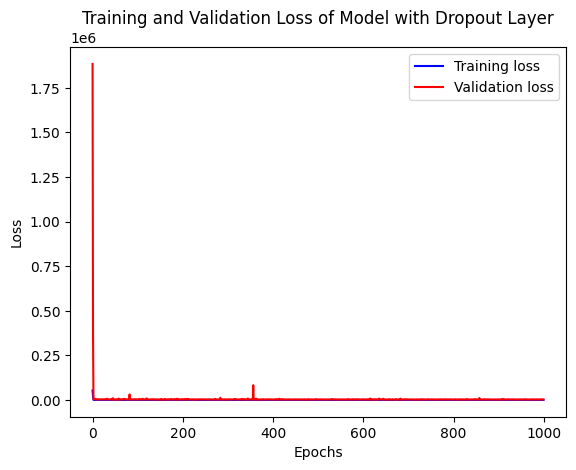

In [ ]:
visualize_loss(history3, "Training and Validation Loss of Model with Dropout Layer")

In [ ]:
y_pred = model3.predict(x_test)

y_pred = y_pred.flatten()
y_test = y_test.flatten()

1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")

MAE: 69.841444229239
MSE: 9821.4628001438
RMSE: 99.10329358877938
R²: 0.9730456572479205
MAPE: 2.4101225160950985


After experimenting with various dropout rates ranging from 0.05 to 0.3, it was observed that lower dropout rates consistently led to reduced error rates. This suggests that applying dropout did not enhance model performance and, in fact, higher dropout rates may have hindered the model's ability to learn effectively from the data. Given these findings, it appears that dropout is not a beneficial regularization technique for this particular dataset. Therefore, for this data, it is advisable to exclude dropout and explore other strategies for model improvement.

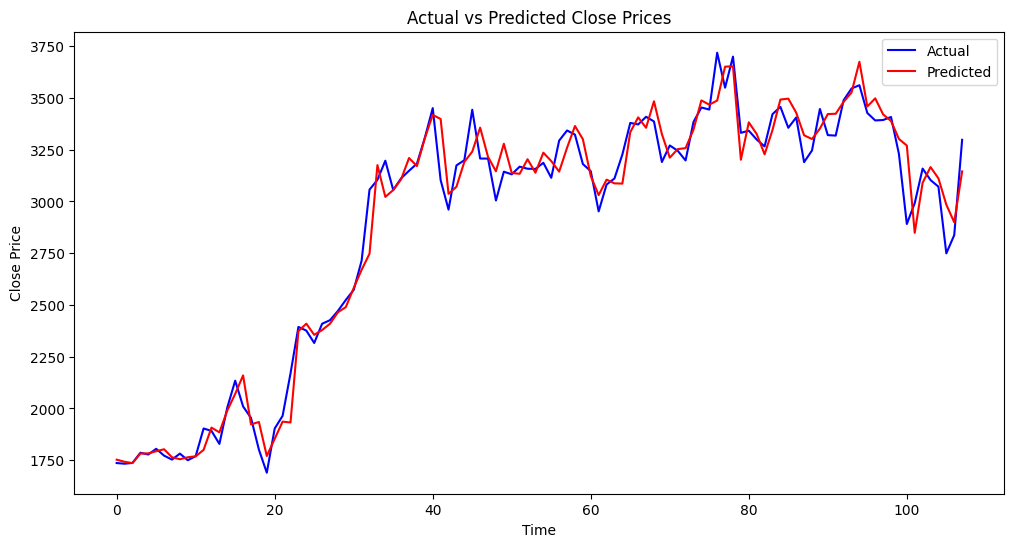

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, color='blue', label='Actual')
plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.legend()
plt.show()

The actual and predicted close prices are closer compared to those in Model 1 and quite similar to those in Model 2.

# Evaluation

In [ ]:
def evaluate_model(model, x_test, y_test):
    predictions = model.predict(x_test)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100

    return rmse, mae, mape

In [ ]:
baseline_rmse, baseline_mae, baseline_mape = evaluate_model(model1, x_test, y_test)

tuned_rmse, tuned_mae, tuned_mape = evaluate_model(best_model, x_test, y_test)

modified_rmse, modified_mae, modified_mape = evaluate_model(model3, x_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
print("Baseline Model Evaluation:")
print(f"RMSE: {baseline_rmse}")
print(f"MAE: {baseline_mae}")
print(f"MAPE: {baseline_mape}%")

print("\nTuned Model Evaluation:")
print(f"RMSE: {tuned_rmse}")
print(f"MAE: {tuned_mae}")
print(f"MAPE: {tuned_mape}%")

print("\nModified Model Evaluation:")
print(f"RMSE: {modified_rmse}")
print(f"MAE: {modified_mae}")
print(f"MAPE: {modified_mape}%")

Baseline Model Evaluation:
RMSE: 110.48126294460079
MAE: 79.58202107349537
MAPE: 2.7477180617568724%

Tuned Model Evaluation:
RMSE: 95.9477899607988
MAE: 67.44802746404802
MAPE: 2.34744982355018%

Modified Model Evaluation:
RMSE: 99.10329358877938
MAE: 69.841444229239
MAPE: 2.4101225160950985%


## Conclusion
The best model here is model 2, which is the tuned model. It has the lowest RMSE, MAE, and MAPE.

Metrics Overview:

* RMSE (Root Mean Squared Error) measures the square root of the average squared differences between predicted and actual values. The RMSE for the modified model is 99.1033, which is lower than the baseline model's RMSE of 110.4813 but higher than the tuned model's RMSE of 95.9478. This indicates that the modified model has reduced prediction errors compared to the baseline, though it is slightly less accurate than the tuned model.

* MAE (Mean Absolute Error) represents the average of the absolute differences between predicted and actual values. The MAE for the modified model is 69.8414, which is lower than the baseline model's MAE of 79.5820 but higher than the tuned model's MAE of 67.4480. This suggests that the modified model provides closer predictions to the actual close prices than the baseline model but is not as precise as the tuned model.

* MAPE (Mean Absolute Percentage Error) measures the average percentage of absolute errors between predicted and actual values. The MAPE for the modified model is 2.4101%, which is better than the baseline model's MAPE of 2.7477% but worse than the tuned model's MAPE of 2.3474%. This indicates that the modified model performs better in terms of relative error compared to the baseline but slightly less well compared to the tuned model

The reduction in RMSE, MAE, and MAPE indicates that the hyperparameter tuning of Model 2 successfully reduced errors compared to the baseline model (Model 1). However, Model 3, which is essentially the same as Model 2 but with the addition of a dropout layer, did not perform better than Model 2.